# Analyse statistique avancée du dataset `edu3-clinical-fr-mesh`
Ce notebook explore la qualité et la complémentarité entre les MeSH détectés par GLiNER et ceux issus de PubMed, ainsi que la couverture des codes CIM-10 associés.

In [1]:
!pip install matplotlib seaborn scikit-learn --quiet

In [2]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import chain
from sklearn.metrics import jaccard_score
import numpy as np
import json

sns.set(style='whitegrid')

/home/cldechau/Documents/AOC/codes/AOC_0/aoc-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ds = load_dataset('clairedhx/edu3-clinical-fr-mesh', split='train')
df = pd.DataFrame(ds)

In [4]:
df

,article_id,article_text,document_type,domain,language,language_score,icd10_trace,detected_entities,mesh_from_gliner,pubmed_mesh,union_mesh,inter_mesh,icd10_codes,icd10_codes_reduct
0,27642398,Le pneumothorax est un épanchement gazeux entr...,Clinical case,clinical,fr,0.999998,"{""J93.11"": {""cui"": ""C1868193"", ""mesh_id"": ""D01...","[{'label': 'disease', 'mesh_id': 'D011030', 't...","[D000420, D002637, D003490, D010994, D011030, ...","[D002637, D006801, D008297, D008875, D011030, ...","[D000420, D002637, D003490, D006801, D008297, ...","[D002637, D011030]","[I26, I26.99, J93.11, J93.83, J93.9, R07.9, R2...","[I26, J93, R07, R23]"
1,30455816,Nous rapportons le cas d’une patiente de 13 an...,Clinical case,biomedical,fr,0.999997,"{""B55"": {""cui"": ""C0023281"", ""mesh_id"": ""D00789...","[{'label': 'symptom', 'mesh_id': 'D006965', 't...","[D000077291, D000935, D006965, D007896, D014376]","[D000077291, D000293, D000935, D001203, D00170...","[D000077291, D000293, D000935, D001203, D00170...","[D000077291, D000935]","[A15-A19, B43.9, B55, B55.9]","[A15-A19, B43, B55]"
2,26523194,Une patiente âgée de 28 ans sans antécédents p...,Clinical case,clinical,fr,0.999998,"{""M54"": {""cui"": ""C0004604"", ""mesh_id"": ""D00141...","[{'label': 'symptom', 'mesh_id': 'D001416', 't...","[D000074402, D000842, D001168, D001416, D00512...","[D000328, D000843, D005260, D006801, D010292, ...","[D000074402, D000328, D000842, D000843, D00116...",[D010292],"[A18.0, A18.01, G82.2, M05-M14, M06.4, M13.0, ...","[A18, G82, M05-M14, M06, M13, M19, M46, M54, R..."
3,26955403,Les plaies par balles peuvent toucher les traj...,Clinical case,biomedical,fr,0.999997,"{""I72.9"": {""cui"": ""C0002940"", ""mesh_id"": ""D000...","[{'label': 'condition', 'mesh_id': 'D000783', ...","[D000783, D010292]","[D005263, D006801, D008297, D010292, D014948, ...","[D000783, D005263, D006801, D008297, D010292, ...",[D010292],"[I72.9, R20.2, W34.00]","[I72, R20, W34]"
4,34381534,L´urticaire correspond à une éruption papuleus...,Clinical case,biomedical,fr,0.999998,"{""L50"": {""cui"": ""C0042109"", ""mesh_id"": ""D01458...","[{'label': 'condition', 'mesh_id': 'D014581', ...","[D006633, D007964, D011537, D014581, D017336]",[],"[D006633, D007964, D011537, D014581, D017336]",[],"[D72.829, L29, L29.9, L50, L50.9]","[D72, L29, L50]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,26161173,Il s'agit d'un patient âgé de 30 ans ayant un ...,Clinical case,biomedical,fr,0.999998,"{""T14.8"": {""cui"": ""C0009938"", ""mesh_id"": ""D003...","[{'label': 'condition', 'mesh_id': 'D011561', ...","[D000793, D003288, D011561, D016570, D019793]","[D000328, D000793, D005451, D006801, D008297, ...","[D000328, D000793, D003288, D005451, D006801, ...","[D000793, D011561]",[T14.8],[T14]
305,28533830,"Il s'agit d'une patiente âgée de 17 ans, sans ...",Clinical case,clinical,fr,0.999997,"{""R04.0"": {""cui"": ""C0014591"", ""mesh_id"": ""D004...","[{'label': 'symptom', 'mesh_id': 'D004844', 't...","[D000772, D004844, D009055, D009278, D009666, ...",[],"[D000772, D004844, D009055, D009278, D009666, ...",[],[R04.0],[R04]
306,25469186,Enfant de 3 ans adressé en Dermatologie pour l...,Clinical case,clinical,fr,0.999995,"{""L53.9"": {""cui"": ""C0041834"", ""mesh_id"": ""D004...","[{'label': 'symptom', 'mesh_id': 'D004890', 't...","[D000667, D004890, D010612, D053878]","[D001003, D002675, D004890, D006801, D010146, ...","[D000667, D001003, D002675, D004890, D006801, ...",[D004890],"[L53.9, R07.0, R52]","[L53, R07, R52]"
307,25404988,Les complications orbitaires d'origine sinusie...,Clinical case,biomedical,fr,0.999995,"{""H05.20"": {""cui"": ""C0015300"", ""mesh_id"": ""D00...","[{'label': 'condition', 'mesh_id': 'D005094', ...","[D000038, D000086722, D000768, D005094, D00533...","[D000038, D002648, D005094, D006801, D008297, ...","[D000038, D000086722, D000768, D002648, D00509...","[D000038, D005094, D009886, D012852]","[H05, H05.20, H05.9, H49.88, J32, R50.9]","[H05, H49, J32, R50]"


In [5]:
df['n_mesh_gliner'] = df['mesh_from_gliner'].apply(len)
df['n_mesh_pubmed'] = df['pubmed_mesh'].apply(len)
df['n_union'] = df['union_mesh'].apply(len)
df['n_inter'] = df['inter_mesh'].apply(len)
df['n_icd10'] = df['icd10_codes'].apply(len)
df['n_icd10_reduct'] = df['icd10_codes_reduct'].apply(len)
df['n_article_text'] = df['article_text'].apply(len)
df[['n_mesh_gliner', 'n_mesh_pubmed', 'n_union', 'n_inter', 'n_icd10', 'n_icd10_reduct', 'n_article_text']].describe()

,n_mesh_gliner,n_mesh_pubmed,n_union,n_inter,n_icd10,n_icd10_reduct,n_article_text
count,309.000000,309.000000,309.000000,309.000000,309.000000,309.00000,309.000000
mean,5.834951,6.556634,11.466019,0.925566,5.080906,3.36246,1545.148867
std,2.992731,3.350838,4.209950,0.888761,3.928326,2.34618,678.856054
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.00000,675.000000
25%,4.000000,6.000000,9.000000,0.000000,2.000000,2.00000,1260.000000
50%,5.000000,7.000000,11.000000,1.000000,4.000000,3.00000,1546.000000
75%,8.000000,9.000000,14.000000,1.000000,7.000000,5.00000,1703.000000
max,18.000000,14.000000,25.000000,4.000000,26.000000,13.00000,9513.000000


In [11]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("almanach/camembert-bio-base")

df["n_subtokens"] = df["article_text"].apply(lambda x: len(tokenizer.tokenize(x)))

df["n_subtokens"].describe()



Token indices sequence length is longer than the specified maximum sequence length for this model (754 > 512). Running this sequence through the model will result in indexing errors


count     309.000000
mean      377.546926
std       162.763498
min       173.000000
25%       305.000000
50%       371.000000
75%       423.000000
max      2229.000000
Name: n_subtokens, dtype: float64

In [46]:
# Fonction Jaccard sur deux listes
def jaccard(a, b):
    a, b = set(a), set(b)
    if not a and not b:
        return np.nan
    return len(a & b) / len(a | b)

# Score global
df['jaccard_mesh'] = df.apply(lambda x: jaccard(x['mesh_from_gliner'], x['pubmed_mesh']), axis=1)
df['jaccard_mesh'].describe()

count    309.000000
mean       0.077946
std        0.077883
min        0.000000
25%        0.000000
50%        0.071429
75%        0.125000
max        0.428571
Name: jaccard_mesh, dtype: float64

In [28]:
#En ne considerant pas les lignes pourlesquelles on a aucun pubmed mesh
df_with_pubmed = df[df['n_mesh_pubmed'] > 0]
df_with_pubmed['jaccard_mesh'].describe()

count    262.000000
mean       0.091929
std        0.076601
min        0.000000
25%        0.000000
50%        0.083333
75%        0.133333
max        0.428571
Name: jaccard_mesh, dtype: float64

In [50]:
def recall_pubmed_in_gliner(pub, gl):
    if not pub:
        return np.nan
    return len(set(pub) & set(gl)) / len(set(pub))

df['recall_mesh_pubmed_in_gliner'] = df.apply(lambda x: recall_pubmed_in_gliner(x['pubmed_mesh'], x['mesh_from_gliner']), axis=1)
df['recall_mesh_pubmed_in_gliner'].describe()

count    262.000000
mean       0.143928
std        0.118849
min        0.000000
25%        0.000000
50%        0.142857
75%        0.200000
max        0.666667
Name: recall_mesh_pubmed_in_gliner, dtype: float64

Text(0.5, 0, 'Nombre de MeSH en commun')

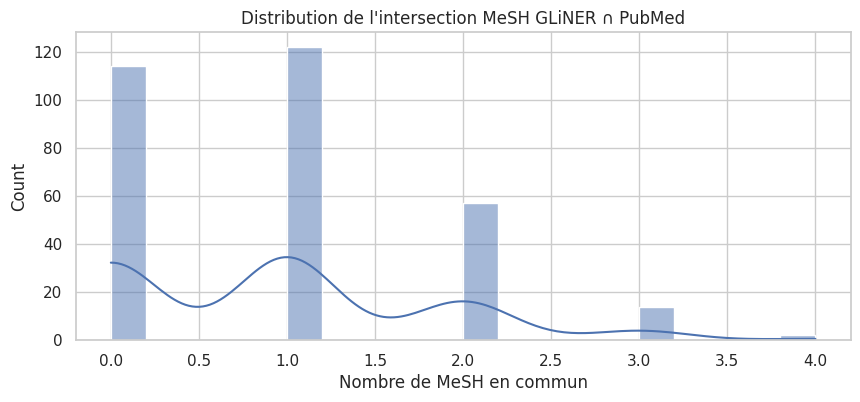

In [33]:
plt.figure(figsize=(10, 4))
sns.histplot(df['n_inter'], bins=20, kde=True)
plt.title("Distribution de l'intersection MeSH GLiNER ∩ PubMed")
plt.xlabel("Nombre de MeSH en commun")

Text(0.5, 1.0, 'Distribution des codes ICD-10 vs. ICD10_reduct')

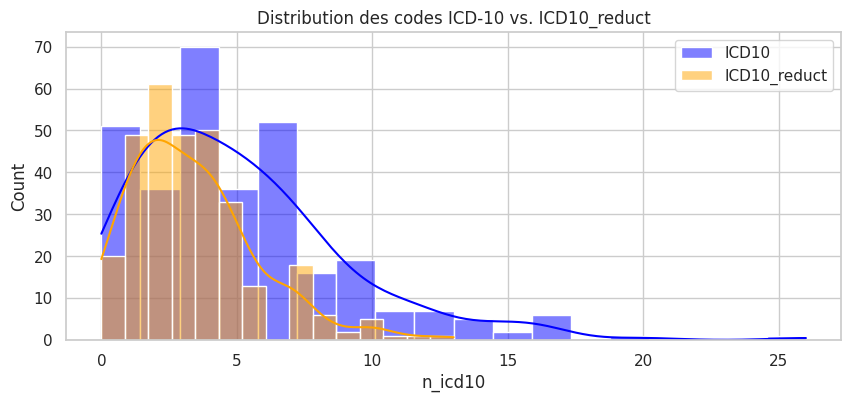

In [34]:
plt.figure(figsize=(10, 4))
sns.histplot(df['n_icd10'], color='blue', label='ICD10', kde=True)
sns.histplot(df['n_icd10_reduct'], color='orange', label='ICD10_reduct', kde=True)
plt.legend()
plt.title('Distribution des codes ICD-10 vs. ICD10_reduct')

In [35]:
icd_flat = list(chain.from_iterable(df['icd10_codes']))
pd.Series(icd_flat).value_counts().head(20)

R50.9      33
R52        28
R06.02     19
R06.0      19
R06.01     19
R06.00     19
R60.9      18
C85.9      17
Z33.1      16
D72.829    13
M54.50     11
M54.5      11
D64.9      11
R11.1      11
R11.10     11
C80.0      10
H26.9      10
D86         9
D80-D89     9
L53.9       9
Name: count, dtype: int64

In [36]:
icd_flat = list(chain.from_iterable(df['icd10_codes_reduct']))
pd.Series(icd_flat).value_counts().head(20)

R50        33
R52        28
D72        21
R06        21
R60        18
C85        17
Z33        16
M54        15
C80        14
H53        14
R11        11
D64        11
H26        10
D80-D89     9
H47         9
L53         9
R10         9
D86         9
H35         8
I10         8
Name: count, dtype: int64

/tmp/ipykernel_2269956/607124312.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_pubmed["icd10_provenances"] = df_with_pubmed["icd10_trace"].apply(extract_provenance)


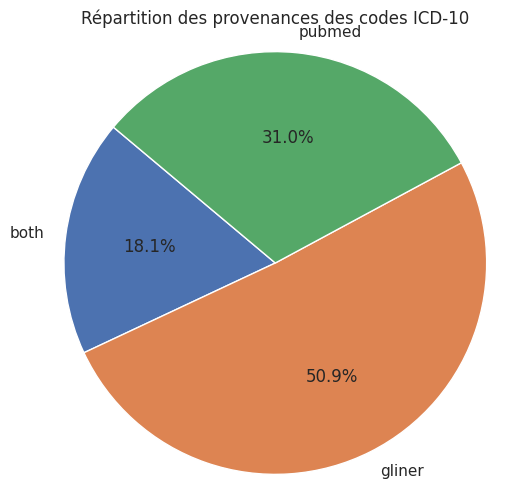

Comptage des provenances : {'both': 256, 'gliner': 720, 'pubmed': 439}


In [63]:
# Fonction robuste d'extraction des provenances
def extract_provenance(trace):
    try:
        if isinstance(trace, dict):
            trace_dict = trace
        elif isinstance(trace, str) and trace.strip():
            trace_dict = json.loads(trace)
        else:
            return []
        return [v.get("provenance") for v in trace_dict.values()]
    except Exception as e:
        print(f"Erreur JSON: {e}")
        return []

# Appliquer à ton DataFrame déjà existant
df_with_pubmed["icd10_provenances"] = df_with_pubmed["icd10_trace"].apply(extract_provenance)

# Aplatir les provenances en une seule liste
all_provs = [p for sublist in df_with_pubmed["icd10_provenances"] for p in sublist]
prov_counts = Counter(all_provs)

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    prov_counts.values(),
    labels=prov_counts.keys(),
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Répartition des provenances des codes ICD-10")
plt.axis("equal")
plt.show()

# Affichage brut
print("Comptage des provenances :", dict(prov_counts))